# Try to enable quantum christmas tree

## classical approach christmas tree
- draw vertical line and some coordinates to connect lines
- array to be x=-30,29 y=0...50

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.utils import QuantumInstance

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator

### try normal way

[[90, 39], [90, 15], [84, 31], [78, 17], [72, 33], [66, 20], [60, 35], [55, 23], [49, 36], [43, 25], [37, 36], [31, 28], [25, 37], [19, 33], [13, 38], [7, 36], [1, 38], [0, 39]]


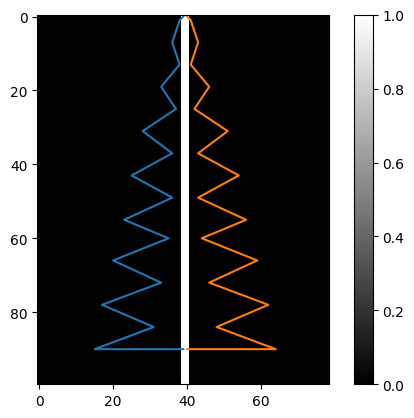

In [2]:
np.random.seed(42)

x_lim_low = -40
x_lim_high = 39

y_lim_low = 0
y_lim_high = 100

height = y_lim_high-y_lim_low
width = x_lim_high-x_lim_low

x_origin = width//2
stem_height = 10
branch_width = 1/3*width

num_values = 16

arr=np.zeros((height,width))

#only use 16 values
tree_widths = [0.9, 0.3, 0.8, 0.2, 0.7, 0.15, 0.6, 0.11, 0.5, 0.10, 0.4, 0.05, 0.2, 0.03, 0.1, 0.01]
tree_distances = [0.5, 0.45, 0.55, 0.5, 0.47, 0.63, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

#initialize first line
for y in range(height):
    arr[y][x_origin]=1
    arr[y][x_origin+1]=1

    
delta_height = (height-stem_height)/(num_values+1)
cur_height = height - stem_height

#starting point is on stem
points = [[height-stem_height, x_origin]]
points_x = [x_origin]
points_y = [height-stem_height]

#now calculate points
for branches in range(num_values):
    y = int(cur_height) #int(cur_height + delta_height*tree_distances[branches])
    x = int(x_origin-(branch_width*tree_widths[branches])) 
    points.append([y, x])
    points_x.append(x)
    points_y.append(y)
    #arr[y][x]=1
    cur_height = int(y - delta_height*(1.5-tree_distances[branches]))

#end point is on stem    
points.append([0, x_origin])
points_x.append(x_origin)
points_y.append(0)

print(points)

#mirror x points on origin
points_x_mir =  np.subtract([2 * x_origin+1]*len(points_x), points_x)

#now connect points
plt.plot(points_x, points_y)
plt.plot(points_x_mir, points_y)
    
plt.imshow(arr, cmap='gray',vmin=0, vmax=1)
plt.colorbar()
plt.show()

### now quantum approach
- take n qubits -> 2^n values of distributions and tweak them to be the branch widths
- take n qubits -> hadamard to determine the distances on the tree

In [3]:
#create circuits
num_qubits = 4

angles = np.linspace(0.5*np.pi, 1.5*np.pi, num_qubits)

values = [16,15/2,14,13/2,12,11/2,10,9/2,8,7/2,6,5/2,4,3/2,2,1]
sum = np.sum(values)
print(sum)

# a(0000), b(0000), a(0001)
init_values = np.sqrt(values/sum)

#proof
print(np.sum(init_values**2))

qc_widths = QuantumCircuit(num_qubits)
qc_widths.initialize(init_values, qc_widths.qubits)
qc_widths.measure_all()

#qc_widths = QuantumCircuit(num_qubits)
#qc_widths.h(0)
#for n in range(1, num_qubits):
#    qc_widths.ry(angles[n-num_qubits], n)
#qc_widths.cx(0,1)
#qc_widths.cx(0,2)
#qc_widths.cx(0,3)
#qc_widths.measure_all()

#make hadamard
qc_height = QuantumCircuit(num_qubits)
for n in range(num_qubits):
    qc_height.h(n)
qc_height.measure_all()

104.5
1.0


In [4]:
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector

backend = Aer.get_backend('aer_simulator')

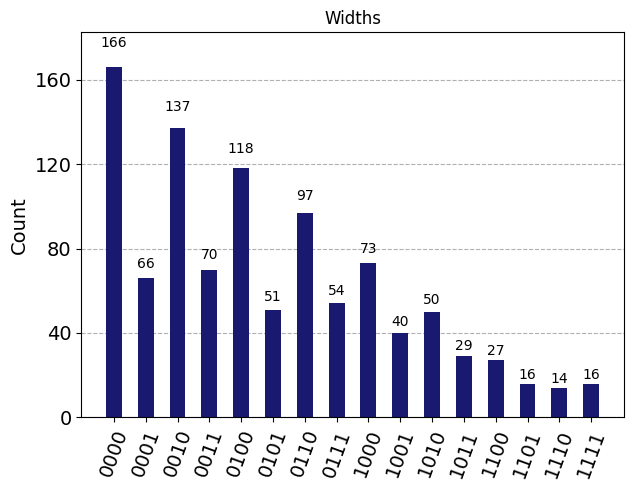

In [5]:
job_widths = execute(qc_widths, backend)
plot_histogram(job_widths.result().get_counts(), color='midnightblue', title="Widths")

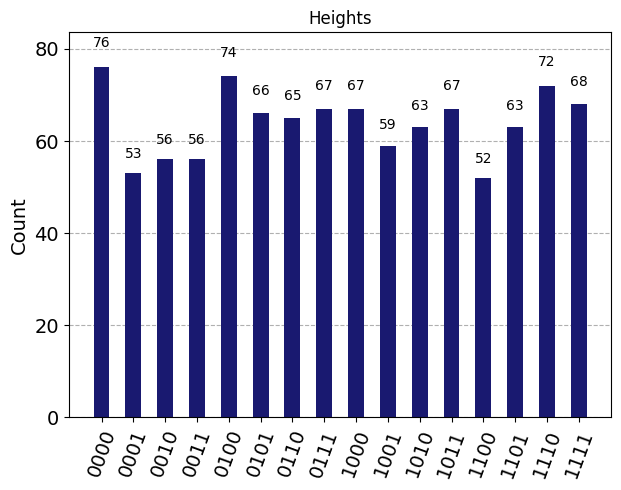

In [6]:
#run circuits and measure results
job_height = execute(qc_height, backend)
plot_histogram(job_height.result().get_counts(), color='midnightblue', title="Heights")

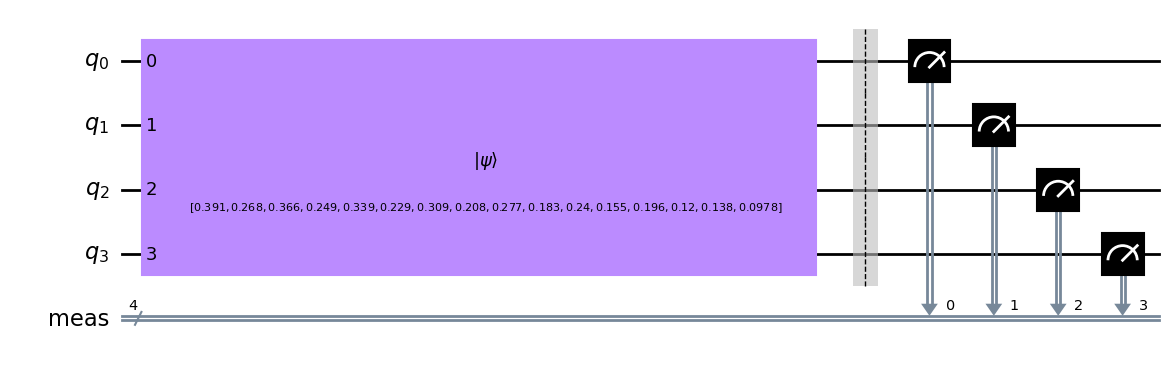

In [7]:
qc_widths.draw('mpl')

In [8]:
#extract points

num_values = 2**num_qubits

tree_widths = []
tree_distances = []

#only use num_values values
#print(job_height.result().get_counts())

shots_h = 0

# get number of shots
for number in job_height.result().get_counts().values():
      shots_h += number

print(shots_h)
        
for counts in range(num_values):
    bin_counts = f'{counts:04b}'
    #print(job_height.result().get_counts()[bin_counts])
    tree_distances.append(job_height.result().get_counts()[bin_counts]*num_values/shots_h/2)

print(tree_distances)
 
#only use num_values values
#print(job_widths.result().get_counts())

shots_w = 0

# get number of shots
for number in job_widths.result().get_counts().values():
      shots_w += number

print(shots_w)
        
for counts in range(num_values):
    bin_counts = f'{counts:04b}'
    #print(job_widths.result().get_counts()[bin_counts])
    tree_widths.append(job_widths.result().get_counts()[bin_counts]*num_values/shots_w/2)

print(tree_widths)    
    
#tree_widths = [0.9, 0.3, 0.8, 0.2, 0.7, 0.15, 0.6, 0.11, 0.5, 0.10, 0.4, 0.05, 0.2, 0.03, 0.1, 0.01]
#tree_distances = [0.5, 0.45, 0.55, 0.5, 0.47, 0.63, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

1024
[0.59375, 0.4140625, 0.4375, 0.4375, 0.578125, 0.515625, 0.5078125, 0.5234375, 0.5234375, 0.4609375, 0.4921875, 0.5234375, 0.40625, 0.4921875, 0.5625, 0.53125]
1024
[1.296875, 0.515625, 1.0703125, 0.546875, 0.921875, 0.3984375, 0.7578125, 0.421875, 0.5703125, 0.3125, 0.390625, 0.2265625, 0.2109375, 0.125, 0.109375, 0.125]


[[90, 39], [90, 4], [85, 25], [79, 10], [73, 24], [67, 14], [62, 28], [56, 19], [50, 27], [44, 23], [38, 30], [32, 28], [26, 33], [20, 33], [14, 35], [8, 36], [3, 35], [0, 39]]


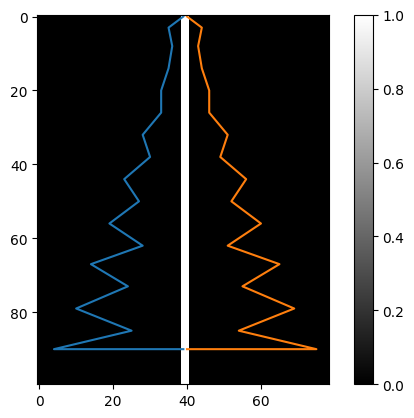

In [9]:
np.random.seed(42)

x_lim_low = -40
x_lim_high = 39

y_lim_low = 0
y_lim_high = 100

height = y_lim_high-y_lim_low
width = x_lim_high-x_lim_low

x_origin = width//2
stem_height = 10
branch_width = 1/3*width

arr=np.zeros((height,width))

num_values = len(tree_widths)

#initialize first line
for y in range(height):
    arr[y][x_origin]=1
    arr[y][x_origin+1]=1

    
delta_height = (height-stem_height)/(num_values+1)
cur_height = height - stem_height

#starting point is on stem
points = [[height-stem_height, x_origin]]
points_x = [x_origin]
points_y = [height-stem_height]

#now calculate points
for branches in range(num_values):
    y = int(cur_height) #int(cur_height + delta_height*tree_distances[branches])
    x = int(x_origin-(branch_width*tree_widths[branches])) 
    points.append([y, x])
    points_x.append(x)
    points_y.append(y)
    #arr[y][x]=1
    cur_height = int(y - delta_height*(1.5-tree_distances[branches]))

#end point is on stem    
points.append([0, x_origin])
points_x.append(x_origin)
points_y.append(0)

print(points)

#mirror x points on origin
points_x_mir =  np.subtract([2 * x_origin+1]*len(points_x), points_x)

#now connect points
plt.plot(points_x, points_y)
plt.plot(points_x_mir, points_y)
    
plt.imshow(arr, cmap='gray',vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright